## BLOG POST ##

In [53]:
import pandas as pd
import regex as re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from spacy.lang.en import English
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split




In [54]:
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/essaarshad/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/essaarshad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/essaarshad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [55]:
covid19_tweets = pd.read_csv("covid19_tweets_updated2.csv")

/var/folders/w6/n78q49k13z3cct9wmrgv4qd40000gn/T/ipykernel_41108/1983776862.py:1: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  covid19_tweets = pd.read_csv("covid19_tweets_updated2.csv")


In [56]:
def remove_emojis(text):
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  
                                   u"\U0001F300-\U0001F5FF"  
                                   u"\U0001F680-\U0001F6FF"  
                                   u"\U0001F700-\U0001F77F"  
                                   u"\U0001F780-\U0001F7FF" 
                                   u"\U0001F800-\U0001F8FF" 
                                   u"\U0001F900-\U0001F9FF"  
                                   u"\U0001FA00-\U0001FA6F" 
                                   u"\U0001FA70-\U0001FAFF"  
                                   u"\U00002702-\U000027B0"  
                                   u"\U000024C2-\U0001F251"  
                                   u"\U000023F3"              
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text  # Return the input value if it's not a string



def remove_trademark_symbols(text):
    if isinstance(text, str):
        trademark_pattern = re.compile(r'\b(\w+)\s*[™®©®]\b', flags=re.IGNORECASE)
        cleaned_text = re.sub(trademark_pattern, r'\1', text)
        return cleaned_text
    
    else:
        return text

  


def replace_special_chars(text):
    if isinstance(text, str):
        special_char_pattern = re.compile("[.@\|!#$%^&*()<>?/\-_|+}{~:,]")
        return special_char_pattern.sub(' ', text)
    else:
        return text 

def clean_value(value):
    if pd.isna(value) or value.strip() == "" or not value:
        return "Unknown"
    cleaned_value = re.sub(r'[^\w\s]', '', value)
    cleaned_value = cleaned_value.strip('. ')
    cleaned_value = re.sub(r'[˙•˚]', '', cleaned_value)
    cleaned_value = re.sub(r'®|™', '', cleaned_value)
    cleaned_value = re.sub(r'[0-9⃣⁷]', '', cleaned_value)
    cleaned_value = ' '.join(cleaned_value.split())
    return cleaned_value


In [57]:
covid19_tweets['user_name'] = covid19_tweets['user_name'].apply(remove_emojis)
covid19_tweets['user_name'] = covid19_tweets['user_name'].apply(replace_special_chars)
covid19_tweets['user_name'] = covid19_tweets['user_name'].apply(remove_trademark_symbols)
covid19_tweets['user_name'] = covid19_tweets['user_name'].apply(clean_value)
covid19_tweets['user_location'] = covid19_tweets['user_location'].fillna('Unknown')
covid19_tweets['user_location'] = covid19_tweets['user_location'].apply(remove_emojis)

In [58]:
covid19_tweets.dropna(subset=['user_created', 'date'], inplace=True)
incorrect_dates = pd.to_datetime(covid19_tweets['user_created'], errors='coerce').isna()
covid19_tweets = covid19_tweets[~incorrect_dates] 
covid19_tweets['user_name'] = covid19_tweets['user_name'].fillna('Unknown')
covid19_tweets['source'] = covid19_tweets['source'].fillna('Unknown')
covid19_tweets['is_retweet'] = covid19_tweets['is_retweet'].fillna(False)
covid19_tweets['is_retweet'] = covid19_tweets['is_retweet'].astype(bool)
covid19_tweets['user_verified'] = covid19_tweets['user_verified'].astype(bool)
covid19_tweets['date'] = pd.to_datetime(covid19_tweets['date'], errors='coerce')
covid19_tweets = covid19_tweets.dropna(subset=['date'])
covid19_tweets['user_verified'] = covid19_tweets['user_verified'].astype(int)
covid19_tweets['is_retweet'] = covid19_tweets['is_retweet'].astype(int)

In [59]:
def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = remove_emojis(text)
    text = re.sub(r'http\S+', '', text)  # remove URLs
    text = re.sub(r'[.@\|!#$%^&*()<>?/\-_|+}{~:,]', ' ', text)  # replace special characters with space
    text = re.sub(r'\b(\w+)\s*[™®©®]\b', r'\1', text)  # remove trademark symbols
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in set(stopwords.words('english'))]
    return ' '.join(words)

In [60]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

data = pd.read_csv("covid19_tweets_updated2.csv")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/essaarshad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/var/folders/w6/n78q49k13z3cct9wmrgv4qd40000gn/T/ipykernel_41108/3906340952.py:6: DtypeWarning: Columns (7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("covid19_tweets_updated2.csv")


In [61]:


def clean_description(text):
    if pd.isna(text):
        return ""  # Return empty string for NaN values
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove emojis and special characters
    text = re.sub('[\p{So}\p{C}]', '', text)
    # Optional: Remove hashtags and mentions
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    # Remove other special characters and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Lemmatize and remove stopwords
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in text.split() if word not in set(stopwords.words('english'))]
    return ' '.join(words)

# Applying the cleaning function to the user_description column
data['user_description'] = data['user_description'].apply(clean_description)








In [62]:
print(data['user_description'])

# convert to csv
# data.to_csv('covid19_tweets_updated2.csv', index=False)

0                   wednesday addams disney princess keepin
1         husband father columnist commentator author to...
2                                               sport lover
3                                                          
4         official twitter handle department information...
                                ...                        
179108           animal scientist muslim real madridchelsea
179109    cat baking soda ninja turtle punk care gamer f...
179110    architect free trade really want world govt co...
179111    global ux ui visual designer storyteller music...
179112    tokelo sekhopa tuky ii last born eish tuky str...
Name: user_description, Length: 179113, dtype: object


In [63]:
# Initialize VADER --> Pre Trained Library

sid = SentimentIntensityAnalyzer()

def get_sentiment(text):
    # Check if the text is NaN
    if pd.isna(text):
        return 'neutral'  # Return 'neutral' for NaN values
    scores = sid.polarity_scores(str(text))  # Convert to string before processing
    if scores['compound'] >= 0.05:
        return 'positive'
    elif scores['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'

# Assuming data is already loaded
data['sentiment'] = data['text'].apply(get_sentiment)

print(data.head(5))

         user_name         user_location  \
0             ᏉᎥլϮ            astroworld   
1      Tom Basile           New York, NY   
2  Time4fisticuffs      Pewee Valley, KY   
3      ethel mertz  Stuck in the Middle    
4         DIPR-J&K     Jammu and Kashmir   

                                    user_description         user_created  \
0            wednesday addams disney princess keepin  2017-05-26 05:46:42   
1  husband father columnist commentator author to...  2009-04-16 20:06:23   
2                                        sport lover  2009-02-28 18:57:41   
3                                                     2019-03-07 01:45:06   
4  official twitter handle department information...  2017-02-12 06:45:15   

   user_followers  user_friends  user_favourites user_verified  \
0           624.0         950.0          18775.0         False   
1          2253.0        1677.0             24.0          True   
2          9275.0        9525.0           7254.0         False   
3       

In [64]:
data['text'].fillna('', inplace=True)

tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english', min_df=3, max_df=0.9)

# Apply the vectorizer
X = tfidf_vectorizer.fit_transform(data['text'])
y = data['sentiment']

In [65]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [66]:
nb_classifier = MultinomialNB(alpha=0.5)
nb_classifier.fit(X_train, y_train)

MultinomialNB(alpha=0.5)

In [67]:
y_pred = nb_classifier.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(metrics.classification_report(y_test, y_pred))

Accuracy: 0.719426067051894
              precision    recall  f1-score   support

    negative       0.75      0.60      0.66      9479
     neutral       0.71      0.74      0.72     12771
    positive       0.71      0.79      0.75     13573

    accuracy                           0.72     35823
   macro avg       0.72      0.71      0.71     35823
weighted avg       0.72      0.72      0.72     35823



In [68]:
scores = cross_val_score(nb_classifier, X, y, cv=5)
print("Cross-validated scores:", scores)

Cross-validated scores: [0.72266421 0.7103816  0.71454094 0.72740216 0.71869242]


In [69]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english', min_df=3, max_df=0.9)
X = tfidf_vectorizer.fit_transform(data['text'])
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

nb_classifier = MultinomialNB(alpha=0.5)
nb_classifier.fit(X_train, y_train)

lr_classifier = LogisticRegression(max_iter=1000)
lr_classifier.fit(X_train, y_train)

ensemble = VotingClassifier(estimators=[
    ('nb', nb_classifier), 
    ('lr', lr_classifier)], 
    voting='soft')
ensemble.fit(X_train, y_train)

y_pred_ensemble = ensemble.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred_ensemble)
print("Accuracy:", accuracy)
print(metrics.classification_report(y_test, y_pred_ensemble))

scores = cross_val_score(ensemble, X, y, cv=5)
print("Cross-validated scores:", scores)

Accuracy: 0.78848784300589
              precision    recall  f1-score   support

    negative       0.83      0.62      0.71      9479
     neutral       0.71      0.93      0.81     12771
    positive       0.87      0.78      0.82     13573

    accuracy                           0.79     35823
   macro avg       0.80      0.77      0.78     35823
weighted avg       0.80      0.79      0.79     35823

Cross-validated scores: [0.79253552 0.78337939 0.78371437 0.79057562 0.7859416 ]


In [70]:
'''
Neural Networks

'''

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train_cat, y_test_cat = train_test_split(X.toarray(), y_categorical, test_size=0.2, random_state=42)

model = Sequential()
model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train_cat, epochs=3, batch_size=64, validation_split=0.1, verbose=1)

loss, accuracy = model.evaluate(X_test, y_test_cat, verbose=0)
print(f"Neural Network Accuracy: {accuracy*100:.2f}%")

/Users/essaarshad/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 512)            │     1,024,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,156,611 (4.41 MB)

 Trainable params: 1,156,611 (4.41 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/3
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.6836 - loss: 0.7398 - val_accuracy: 0.7964 - val_loss: 0.5676
Epoch 2/3
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8033 - loss: 0.5429 - val_accuracy: 0.7998 - val_loss: 0.5535
Epoch 3/3
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - accuracy: 0.8182 - loss: 0.4896 - val_accuracy: 0.8011 - val_loss: 0.5475
Neural Network Accuracy: 80.54%


1120/1120 ━━━━━━━━━━━━━━━━━━━━ 1s 665us/step


<Figure size 1000x1000 with 0 Axes>

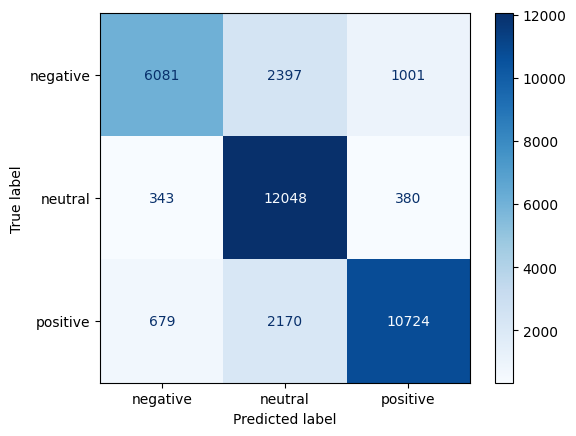

In [71]:
# Predict classes with the neural network model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred_prob_nn = model.predict(X_test)
y_pred_nn = np.argmax(y_pred_prob_nn, axis=1)

# Decode the predictions and true values back to original labels
y_pred_labels_nn = label_encoder.inverse_transform(y_pred_nn)
y_true_labels = label_encoder.inverse_transform(np.argmax(y_test_cat, axis=1))

# Confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels_nn, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Plot the confusion matrix
plt.figure(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues)
plt.show()

Accuracy of Logistic Regression: 0.80
              precision    recall  f1-score   support

    negative       0.85      0.63      0.72      9479
     neutral       0.72      0.95      0.82     12771
    positive       0.88      0.78      0.83     13573

    accuracy                           0.80     35823
   macro avg       0.82      0.78      0.79     35823
weighted avg       0.81      0.80      0.79     35823



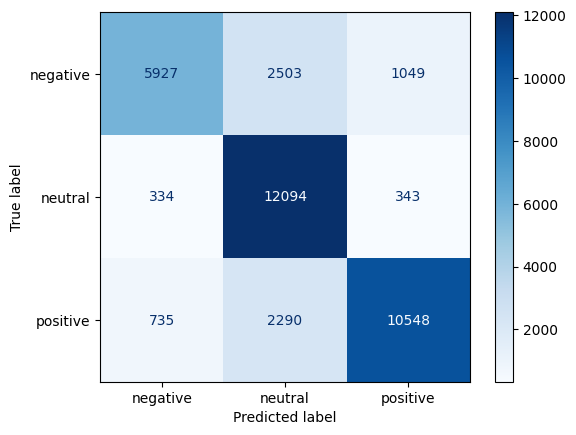

In [72]:
'''Logistic Regression'''

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
# Using a high value for 'max_iter' to ensure convergence
logreg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
logreg.fit(X_train, y_train)

# Predicting the test set results
y_pred = logreg.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression: {accuracy:.2f}")

# Detailed performance report
print(classification_report(y_test, y_pred))

# Confusion Matrix Display
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.show()

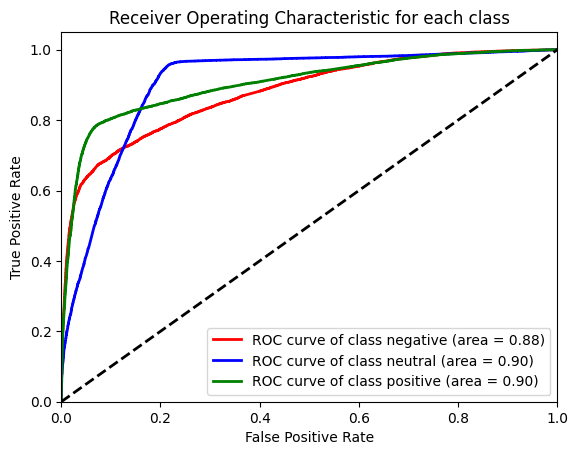

In [73]:
'''One vs Rest Multiclass Classification using Logistic Regression'''

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'X' is your feature set and 'y' contains the original class labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the model for multiclass classification
logreg_multi = LogisticRegression(max_iter=1000, multi_class='ovr')
logreg_multi.fit(X_train, y_train)

# Since we are doing one-vs-rest, we need to calculate the ROC AUC for each class
y_score = logreg_multi.decision_function(X_test)

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(logreg_multi.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(y_test == logreg_multi.classes_[i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, color in zip(range(logreg_multi.classes_.size), ['red', 'blue', 'green', 'purple']):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(logreg_multi.classes_[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for each class')
plt.legend(loc="lower right")
plt.show()


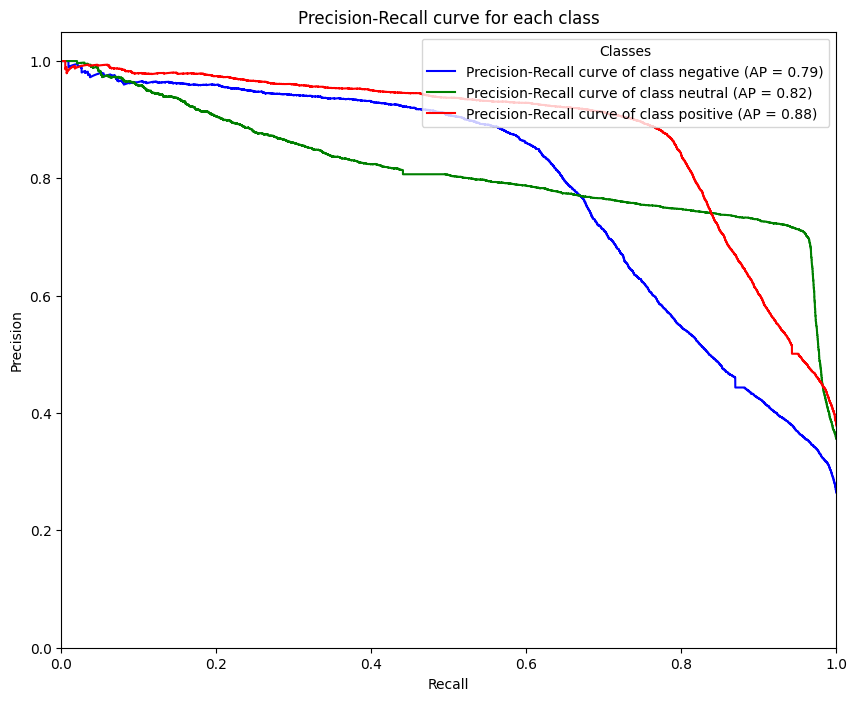

In [74]:
from sklearn.calibration import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

classes = np.unique(y)
n_classes = len(classes)

# Binarize the labels for plotting
y_train_bin = label_binarize(y_train, classes=classes)
y_test_bin = label_binarize(y_test, classes=classes)


logreg_multi = LogisticRegression(max_iter=1000, multi_class='ovr')
logreg_multi.fit(X_train, y_train)

from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from itertools import cycle

# Define colors for each class
colors = cycle(['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black'])

precision = dict()
recall = dict()
average_precision = dict()

# Decision function is needed to calculate precision-recall
decision_scores = logreg_multi.decision_function(X_test)

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], decision_scores[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], decision_scores[:, i])


plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.step(recall[i], precision[i], color=color, where='post',
             label='Precision-Recall curve of class {0} (AP = {1:0.2f})'.format(classes[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve for each class')
plt.legend(loc="upper right", title="Classes")
plt.show()




